Security Metrics Maturity

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt

## decision-first, predictive analytics

In [156]:
def plot_maturity(x_labels, y_labels, fig_size=(10, 10), tick_size=10, annots=[], show_direction=True):
    """
    
    
    params:
        x_labels:
        y_labels:
        fig_size: 
        tick_size:
        annots:
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fig_size)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    if show_direction:
        plt.plot(range(len(x_labels)+1), range(len(y_labels)+1), 'r')
        plt.arrow(0.5, 0.5, 0.1, 0.1, width=0.05, color='r')
    
    ax.set_xticks(list(range(1, len(x_labels)+1)))
    ax.set_yticks(list(range(1, len(y_labels)+1)))
    ax.set_xticklabels(x_labels, fontsize=tick_size)
    ax.set_yticklabels(y_labels, fontsize=tick_size)
    
    for (x,y), annot_string in annots:
        ax.annotate(annot_string, (x,y), fontsize=tick_size)
    
    plt.show()

In [157]:
xlabels = ['beliefs & \nad-hoc data', 
           'security vendor\n data', 
           'integrated data\n sources',
           'unstructured real-\ntime big data']
ylabels = ['what should I \n invest?', 
           'Is individual \ninvestment working?', 
           'Are investments\n working together?',
           'Am I finding &\n stopping hidden threats?']
annots = [((0.7, 0.8), 'sparse data\n analytics'),
          ((1.7, 1.8), 'functional\n security metrics'),
          ((2.7, 2.8), 'security\n data marts'),
          ((3.7, 3.8), 'prescriptive\n analytics')]

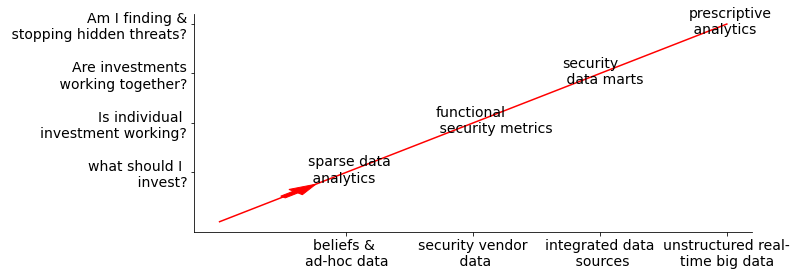

In [158]:
plot_maturity(xlabels, ylabels, tick_size=14, fig_size=(10, 4),
             annots=annots)

## sparse data analytics